In [ ]:
!cp drive/MyDrive/LICENTA-DATASET/flickr30k-captions-ro.tar.gz .
!cp drive/MyDrive/LICENTA-DATASET/flickr30k-images.tar.gz .
%mkdir flickr30k-captions-ro
!tar -xf flickr30k-captions-ro.tar.gz -C ./flickr30k-captions-ro
!tar -xf flickr30k-images.tar.gz

mkdir: cannot create directory ‘flickr30k-captions-ro’: File exists


### Image Encoders:
* ResNet50 or ResNet50v2
* InceptionV3 or Inception v4 or Inception-ResNet v1 or Inception-ResNet v2
* EfficientNet B4 or EfficientNet B7?
* ViT_B_16 or ViT_H_14

### Text Encoder:
* RNN
* GRU
* LSTM
* LSTM + Dot Attention

In [ ]:
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score
!pip install git+https://github.com/michelecafagna26/cider.git#egg=cidereval
!pip install vit-keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import ResNet50, ResNet50V2, InceptionV3, InceptionResNetV2, EfficientNetB4, EfficientNetB7
from keras.layers import LSTM, GRU, Input, Dense, Embedding, Dropout, Attention, GlobalAveragePooling2D, Reshape, TextVectorization
from keras.layers import RandomFlip, RandomRotation, RandomContrast
from keras.layers import Add, Concatenate
from keras.models import Model

import evaluate
from cidereval import cider, ciderD
from vit_keras import vit, utils
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
ter = evaluate.load("ter")
rouge = evaluate.load("rouge")

keras.utils.set_random_seed(111)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
IMAGES_PATH = "flickr30k-images"
CAPTIONS_PATH = "flickr30k-captions-ro/flickr30k-captions_ro-v5.txt"
IMAGE_SIZE = (224, 224)
VOCAB_SIZE = 24157
SEQ_LENGTH = 25
EMBED_DIM = "512" # @param[128, 256, 512]
EMBED_DIM = int(EMBED_DIM)
FF_DIM = "512" # @param[128, 256, 512]
FF_DIM = int(FF_DIM)
LSTM_DIM = "256" # @param[128, 256, 512]
LSTM_DIM = int(LSTM_DIM)
GRU_DIM = "256" # @param[128, 256, 512]
GRU_DIM = int(GRU_DIM)
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Preparing the dataset

In [ ]:
!wget https://raw.githubusercontent.com/dima331453/Flickr30k-Romanian/main/flickr30k_romanian.tsv

--2024-06-15 20:41:10--  https://raw.githubusercontent.com/dima331453/Flickr30k-Romanian/main/flickr30k_romanian.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25618304 (24M) [text/plain]
Saving to: ‘flickr30k_romanian.tsv’

flickr30k_romanian. 100%[===================>]  24.43M  --.-KB/s    in 0.1s    

2024-06-15 20:41:12 (180 MB/s) - ‘flickr30k_romanian.tsv’ saved [25618304/25618304]



In [ ]:
CAPTIONS_PATH = "./flickr30k_romanian.tsv"

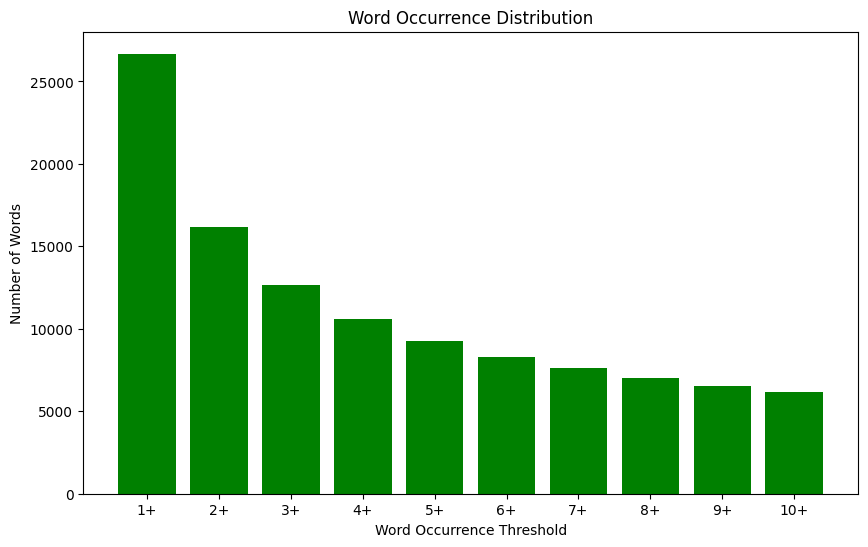

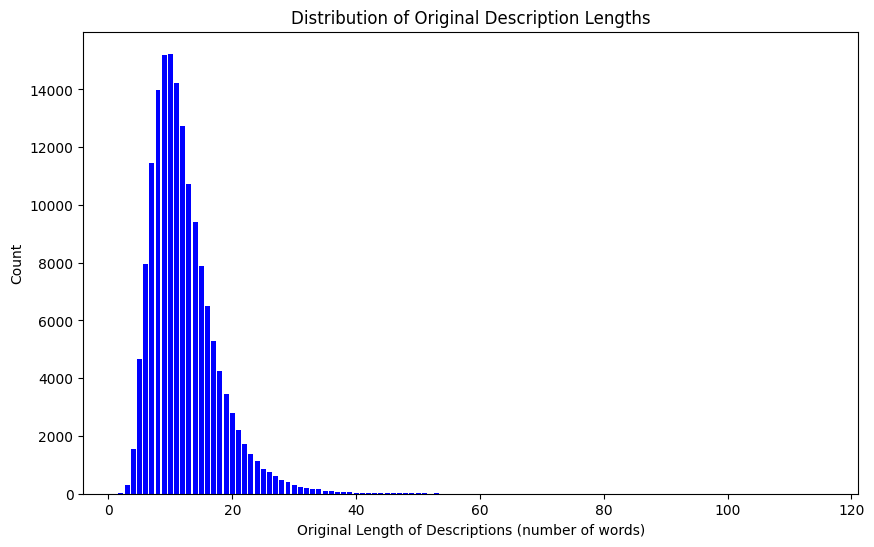

startseq un bărbat asiatic în costum neagru stă lângă o femeie cu păr întunecat și o femeie cu păr unk endseq
['un', 'bărbat', 'asiatic', 'în', 'costum', 'neagru', 'stă', 'lângă', 'o', 'femeie', 'cu', 'păr', 'întunecat', 'și', 'o', 'femeie', 'cu', 'păr', 'saten']
startseq cinci balerine surprinse în mijlocul unei sărituri întrun studio de dans cu soarele unk printro fereastră endseq
['cinci', 'balerine', 'surprinse', 'în', 'mijlocul', 'unei', 'sărituri', 'întrun', 'studio', 'de', 'dans', 'cu', 'soarele', 'pătrunzând', 'printro', 'fereastră']
startseq cinci fete dansează și își unk picioarele întro clasă de balet endseq
['cinci', 'fete', 'dansează', 'și', 'își', 'îndoiesc', 'picioarele', 'întro', 'clasă', 'de', 'balet']
startseq o clasă de balet cu cinci fete sărind întro unk endseq
['o', 'clasă', 'de', 'balet', 'cu', 'cinci', 'fete', 'sărind', 'întro', 'succesiune']
startseq fată în jachetă neagră unk zahăr pudră peste un tort de ciocolată endseq
['fată', 'în', 'jachetă', 'neagră', 'ce

In [ ]:
from os import listdir, mkdir
import string
import random
from random import shuffle
from collections import defaultdict
SEQ_LENGTH = 25
WORD_THRESHOLD = 2

def load_descriptions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()

    mapping = dict()
    first = True
    for line in doc.split('\n'):
        if first:
          first = False
          continue
        tokens = line.split('\t')
        if len(line) < 4:
            continue


        image_id, image_desc = tokens[1], tokens[3:]
        image_id = "flickr30k-images/" + image_id.split('#')[0]
        image_desc = ' '.join(image_desc)

        if image_id not in mapping:
            mapping[image_id] = list()

        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions, seq_len, word_threshold):
    # prepare translation table for removing punctuation

    length_counts = {}

    word_counts = defaultdict(int)

    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]

            original_length = len(desc)

            if original_length in length_counts:
                length_counts[original_length] += 1
            else:
                length_counts[original_length] = 1

            for word in desc[:seq_len]:
                word_counts[word] += 1

    plot_word_occurrence_distribution(word_counts)
    plot_length_distribution(length_counts)
    #####
    first = 5
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            desc_backup = list(desc)
            desc = [word if word_counts[word] >= word_threshold else 'unk' for word in desc]

            # store as string
            desc_list[i] =  'startseq ' + ' '.join(desc[:seq_len]) + ' endseq'

            if 'unk' in desc_list[i] and first > 0:
              print(desc_list[i])
              print(desc_backup)
              first -=  1


def plot_length_distribution(length_counts):
    # Convert the length_counts dictionary to two lists: one for lengths and one for counts
    lengths = list(length_counts.keys())
    counts = list(length_counts.values())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(lengths, counts, width=0.8, color='blue')
    plt.xlabel('Original Length of Descriptions (number of words)')
    plt.ylabel('Count')
    plt.title('Distribution of Original Description Lengths')
    plt.show()

def plot_word_occurrence_distribution(word_counts):
    # Create a list to store the number of words that occur at least 1, 2, ..., 5 times
    occurrence_counts = [0] * 10

    for count in word_counts.values():
        for i in range(10):
            if count > i:
                occurrence_counts[i] += 1

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 11), occurrence_counts, width=0.8, color='green')
    plt.xlabel('Word Occurrence Threshold')
    plt.ylabel('Number of Words')
    plt.title('Word Occurrence Distribution')
    plt.xticks(range(1, 11), ['1+', '2+', '3+', '4+', '5+','6+', '7+', '8+', '9+', '10+'])
    plt.show()


def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

descriptions = load_descriptions(CAPTIONS_PATH)
clean_descriptions(descriptions, SEQ_LENGTH, WORD_THRESHOLD)
vocabulary = to_vocabulary(descriptions)

all_items = ["flickr30k-images/" + line for line in listdir(IMAGES_PATH)]
random.seed(42)
random.shuffle(all_items)

train_items = set(all_items[:-5000])
train_descriptions =  {key: value for key, value in descriptions.items() if key in train_items}

test_items = set(all_items[-5000:])
test_descriptions =  {key: value for key, value in descriptions.items() if key in test_items}

In [ ]:
vocab_size = len(vocabulary)

# Vectorizing the text data

In [ ]:
merged_list = [item for sublist in train_descriptions.values() for item in sublist]

In [ ]:
vectorization = TextVectorization(
    output_mode="int",
    vocabulary=list(vocabulary),
    output_sequence_length=SEQ_LENGTH,
)
vocab_size = len(vectorization.get_vocabulary())
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomContrast(0.3),
    ]
)

In [ ]:
print(len(vectorization.get_vocabulary()))

16183


# Building a tf.data.Dataset pipeline for training

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_descriptions.keys()), list(train_descriptions.values()))

valid_dataset = make_dataset(list(test_descriptions.keys()), list(test_descriptions.values()))

# Building the model

In [ ]:
def get_cnn_model(model_name):
    base_model = None

    if model_name == "ResNet50":
      base_model = ResNet50(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "ResNet50V2":
      base_model = ResNet50V2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "InceptionV3":
      base_model = InceptionV3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "InceptionResNetV2":
      base_model = InceptionResNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "EfficientNetB4":
      base_model = EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "EfficientNetB7":
      base_model = EfficientNetB7(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "ViT":
      base_model = vit.vit_b16(
        pretrained=True)
    else:
      base_model = None
      return None

    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=vocab_size,
        )
        self.out = layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


In [ ]:
def get_cnn_model(model_name):
    base_model = None

    if model_name == "ResNet50":
      base_model = ResNet50(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "ResNet50V2":
      base_model = ResNet50V2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "InceptionV3":
      base_model = InceptionV3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "InceptionResNetV2":
      base_model = InceptionResNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "EfficientNetB4":
      base_model = EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "EfficientNetB7":
      base_model = EfficientNetB7(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
      )
    elif model_name == "ViT":
      base_model = vit.vit_b16(
        pretrained=True)
    else:
      base_model = None
      return None

    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.layers[-3].output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

cnn_model = get_cnn_model("ViT")
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_13 (Reshape)        (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
MODEL_NAME = "ResNet50" #@param ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7"]
cnn_model = get_cnn_model(MODEL_NAME)
cnn_model.summary()

In [ ]:
MODEL_NAME = "ResNet50" #@param ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7"]
cnn_model = get_cnn_model(MODEL_NAME)
FF_DIM = 512
EMBED_DIM = 512
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=6)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=6)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [ ]:
index_lookup = dict(zip(range(len(vectorization.get_vocabulary())), vectorization.get_vocabulary()))
max_decoded_sentence_length = SEQ_LENGTH - 1

def generate_desc_batch(paths):
    batch_size = len(paths)

    batch_imgs = [decode_and_resize(path) for path in paths]
    batch_imgs = tf.stack(batch_imgs)
    batch_imgs = tf.clip_by_value(batch_imgs, 0.0, 1.0)
    batch_imgs = tf.cast(batch_imgs * 255.0, tf.uint8)
    cnn_features = caption_model.cnn_model(batch_imgs)
    encoded_imgs = caption_model.encoder(cnn_features, training=False)

    # Generate the caption using the Transformer decoder
    completed_descriptions = [''] * batch_size
    in_texts = ['startseq'] * batch_size
    for i in range(max_decoded_sentence_length):
        tokenized_captions = vectorization(in_texts)[:, :-1]
        mask = tf.math.not_equal(tokenized_captions, 0)
        predictions = caption_model.decoder(
            tokenized_captions, encoded_imgs, training=False, mask=mask
        )
        sampled_tokens_index = np.argmax(predictions[:, i, :], axis=1)
        sampled_tokens = [index_lookup[sampled_token_index] for sampled_token_index in sampled_tokens_index]

        for j in range(batch_size):
            word = sampled_tokens[j]
            if word is None or word == 'endseq':
                continue
            in_texts[j] += ' ' + word
            completed_descriptions[j] = in_texts[j]

    completed_descriptions =  [desc.replace("startseq ", "").replace(" endseq", "").strip() for desc in completed_descriptions]

    return completed_descriptions

# Model training

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
from tqdm import tqdm
df_results = pd.DataFrame()
EPOCHS = 10
for MODEL_NAME in ["ViT"]:
  print(MODEL_NAME)
  cnn_model = get_cnn_model(MODEL_NAME)
  FF_DIM = 512
  EMBED_DIM = 512
  encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=6)
  decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=6)
  caption_model = ImageCaptioningModel(
      cnn_model=cnn_model,
      encoder=encoder,
      decoder=decoder,
      image_aug=image_augmentation,
  )


  cross_entropy = keras.losses.SparseCategoricalCrossentropy(
      from_logits=False,
  )


  #savve cp
  checkpoint_path = "training_" + MODEL_NAME + "_idk/cp-{epoch:04d}.ckpt"

  n_batches = len(train_descriptions) / BATCH_SIZE
  import math
  n_batches = math.ceil(n_batches)

  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      verbose=1,
      save_weights_only=True,
      save_freq=1*n_batches)

  # Learning Rate Scheduler for the optimizer
  class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
      def __init__(self, post_warmup_learning_rate, warmup_steps):
          super().__init__()
          self.post_warmup_learning_rate = post_warmup_learning_rate
          self.warmup_steps = warmup_steps

      def __call__(self, step):
          global_step = tf.cast(step, tf.float32)
          warmup_steps = tf.cast(self.warmup_steps, tf.float32)
          warmup_progress = global_step / warmup_steps
          warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
          return tf.cond(
              global_step < warmup_steps,
              lambda: warmup_learning_rate,
              lambda: self.post_warmup_learning_rate,
          )


  # Create a learning rate schedule
  num_train_steps = len(train_dataset) * EPOCHS
  num_warmup_steps = num_train_steps // 15
  lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

  # Compile the model
  caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

  # Fit the model
  caption_model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data=valid_dataset,
      callbacks=[cp_callback],
  )

  n_batches_test = len(test_descriptions) / BATCH_SIZE
  n_batches_test  = math.ceil(n_batches_test )


  image_paths = [key for key in test_descriptions.keys()]
  preds = []
  for i in tqdm(range(0,
                      len(test_descriptions),
                      50)):
    preds += generate_desc_batch(image_paths[i:i+50])

  refs = []
  for descs in list(test_descriptions.values()):
    new_descs = []
    for desc in descs:
      new_descs.append(desc.replace("startseq ", "").replace(" endseq", ""))
    refs.append(new_descs)


  results = bleu.compute(predictions=preds, references=refs)
  b1, b2, b3, b4 = results['precisions']
  results = meteor.compute(predictions=preds, references=refs)
  met = results['meteor']
  results = ter.compute(predictions=preds, references=refs)
  te = results['score']
  results = rouge.compute(predictions=preds, references=refs)
  rougeL, r1, r2 = results['rougeL'], results['rouge1'], results['rouge2']
  results = cider(predictions=preds, references=refs, df='corpus')
  cid = results['avg_score']

  new_data = pd.DataFrame({'model': [f"{MODEL_NAME}-tf"],
                          'B-1': [b1], 'B-2': [b2], 'B-3': [b3], 'B-4': [b4],
                          'CIDEr': [cid], 'R-1': [r1], 'R-2': [r2], 'Rouge-L': [rougeL], 'Meteor': [met], 'TER': [te]})

  df_results = pd.concat([df_results, new_data], ignore_index=True)
  print(df_results)

ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/10
418/419 [============================>.] - ETA: 2s - loss: 22.5895 - acc: 0.1954
Epoch 1: saving model to training_ViT_idk/cp-0001.ckpt
419/419 [==============================] - 1325s 3s/step - loss: 22.5793 - acc: 0.1957 - val_loss: 18.3176 - val_acc: 0.3008
Epoch 2/10
418/419 [============================>.] - ETA: 2s - loss: 17.5888 - acc: 0.3123
Epoch 2: saving model to training_ViT_idk/cp-0002.ckpt
419/419 [==============================] - 1299s 3s/step - loss: 17.5888 - acc: 0.3123 - val_loss: 16.9240 - val_acc: 0.3247
Epoch 3/10
418/419 [============================>.] - ETA: 2s - loss: 16.5009 - acc: 0.3321
Epoch 3: saving model to training_ViT_idk/cp-0003.ckpt
419/419 [==============================] - 1299s 3s/step - loss: 16.5006 - acc: 0.3321 - val_loss: 16.3496 - val_acc: 0.3355
Epoch 4/10
418/419 [============================>.] - ETA: 2s - loss: 15.8501 - acc: 0.3440
Epoch 4: saving model to training_ViT_idk/cp-0004.ckpt
419/419 [============================

100%|██████████| 100/100 [04:21<00:00,  2.61s/it]


    model       B-1       B-2       B-3       B-4     CIDEr      R-1  \
0  ViT-tf  0.278058  0.036847  0.007952  0.001267  0.036839  0.22651   

        R-2   Rouge-L    Meteor         TER  
0  0.038815  0.196583  0.162731  133.074605  


In [ ]:
import pickle

pickle.dump({'config': vectorization.get_config(),
             'weights': vectorization.get_weights()}, open("training_" + MODEL_NAME + "_2/ro_vectorization.pkl", 'wb'))